In [1]:
%matplotlib inline

from IPython.display import display
from IPython.display import Image

import GPUtil
from cpuinfo import get_cpu_info
import platform
import psutil

In [2]:
def printSystemInfo():
    print("OS:")
    print("\t" + platform.system(), platform.release())
    print("\t" + platform.machine() + "\n")

    print("CPU:\n", "\t" + get_cpu_info()["brand_raw"] + "\n")

    print("RAM:\n\t" + str(round(psutil.virtual_memory().total / (1024.0 **3))), "GB")
    
    print("GPU:")
    for gpu in GPUtil.getGPUs():
        print("\tName:", gpu.name)
        print("\tDrivers:", gpu.driver)
        print("\tVideo memory:", round(gpu.memoryTotal / 1024), "GB")

# Realistic simulation of X-ray radiographs using gVirtualXRay
## With a realistic beam spectrum and taking into account the energy response of the detector
### Authors: F. P. Vidal and J. M. Létang

**Purpose:** In this notebook, we aim to demonstrate how to use gVirtualXRay to generate analytic simulations on GPU. We take into account i) a realistic anatomical phantom, ii) a realistic clinical scenario, iii) a realistic beam spectrum, iv) the energy response of the detector, and v) the CT acquisition parameters.

**Material and Methods:** We downloaded the paediatric phantom from the [p**E**diat**R**ic dosimet**R**y personalized platf**OR**m (ERROR) project](https://error.upatras.gr/). It corresponds to the anatomy of a 5 year old boy. We generated surfaces meshes from the segmented data using [VTK](https://www.vtk.org/). We used the definitions of tissue substitutes provided in the [ICRU Report 44](https://www.icru.org/report/tissue-substitutes-in-radiation-dosimetry-and-measurement-report-44/) by the [International Commission on Radiation Units and Measurements](https://www.icru.org/). The material composition is available at [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html).
We performed 1000 projections around the virtual patient and reconstructed the CT volume using CERN's tomography reconstruction framework: [Tigre](https://github.com/CERN/TIGRE).

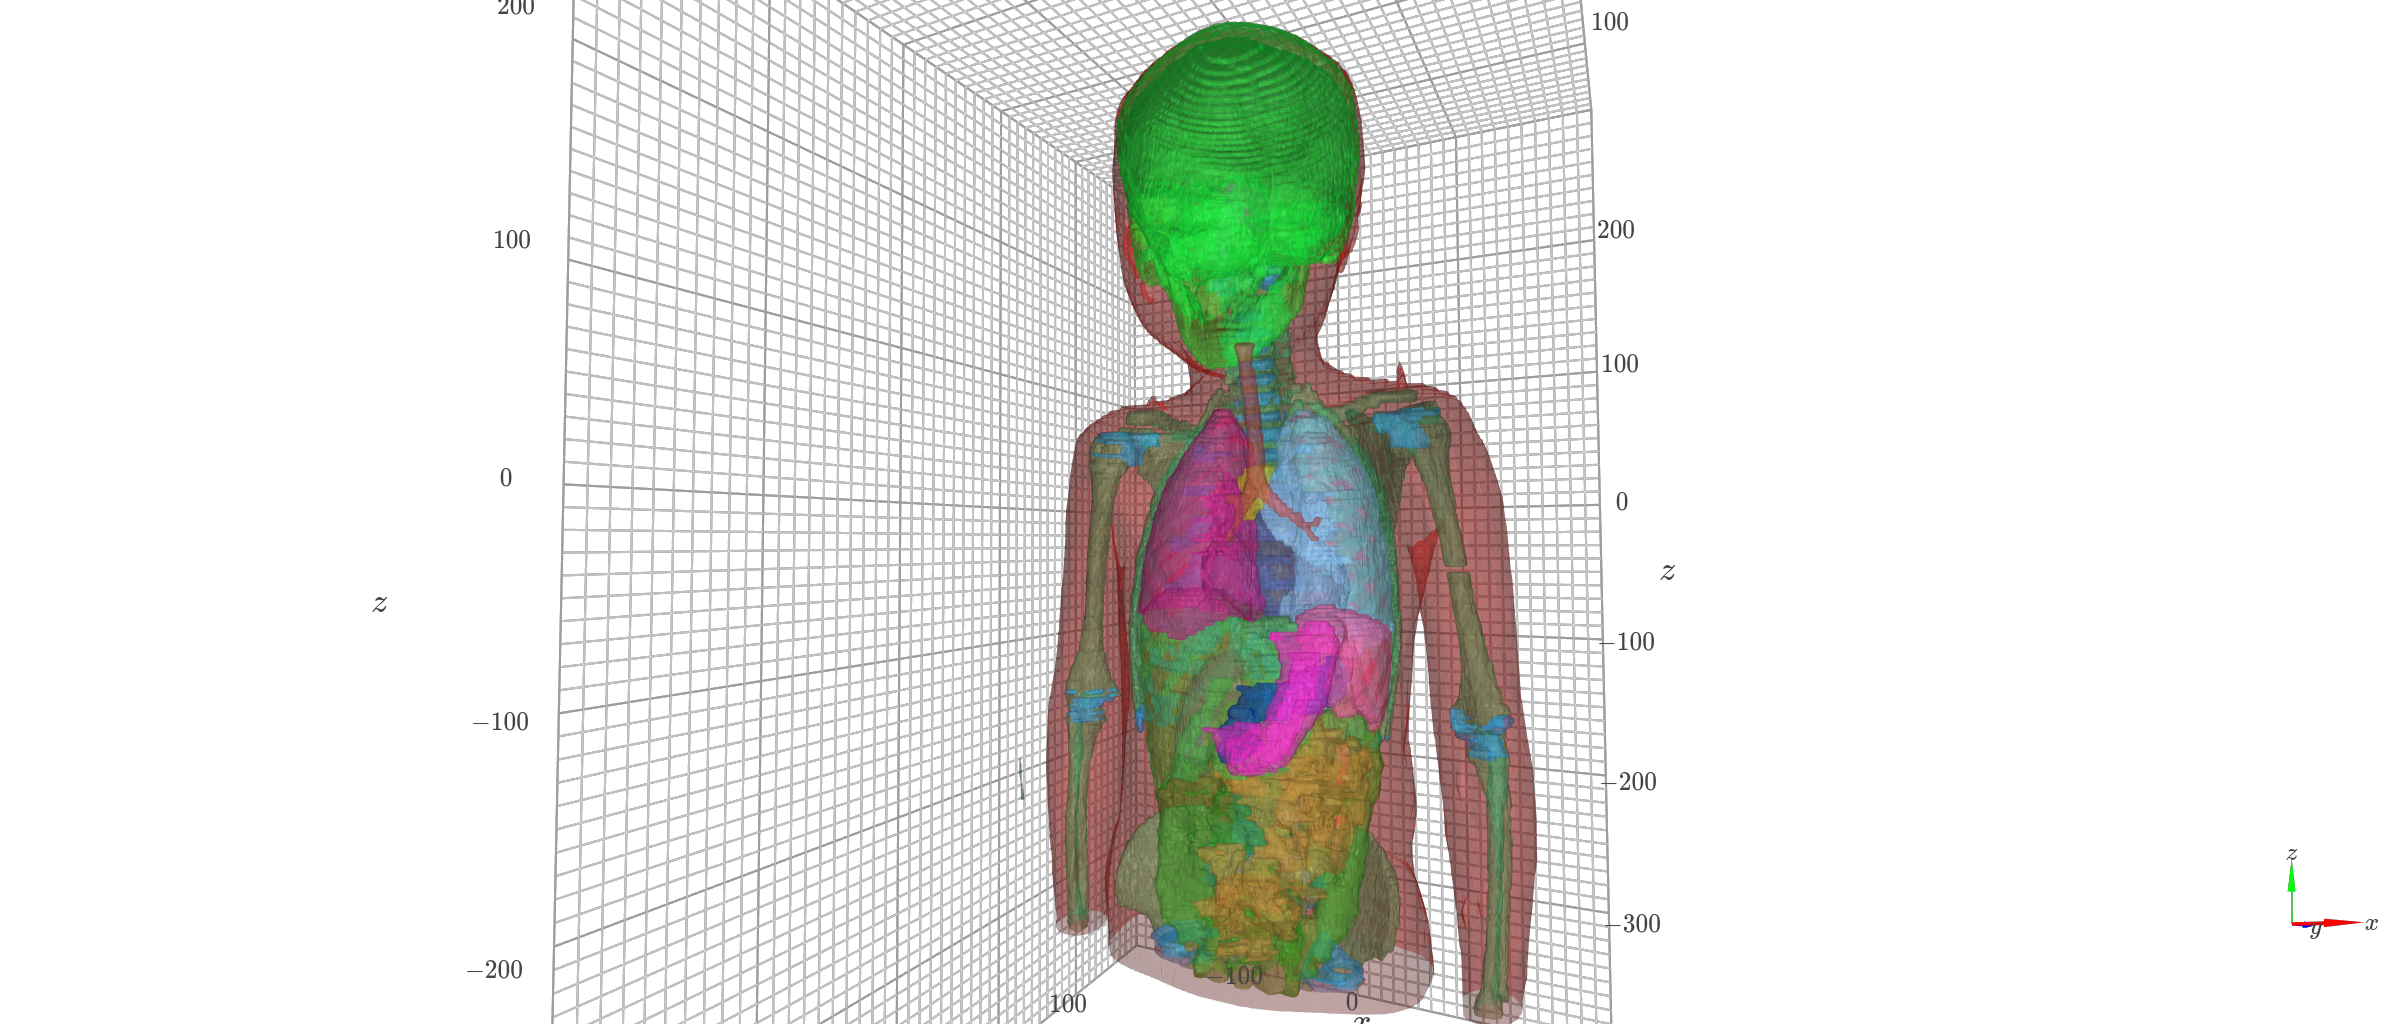

In [3]:
Image(filename="pediatric_model.png", width=800)

In our simulation the source-to-object distance (SOD) is 1000mm, and the source-to-detector distance (SDD) is 1125mm. The beam spectrum is polychromatic. The voltage is 85 kV. The filteration is 0.1 mm of copper and 1 mm of aluminium. The energy response of the detector is considered. It mimics a 600-micron thick CsI scintillator.

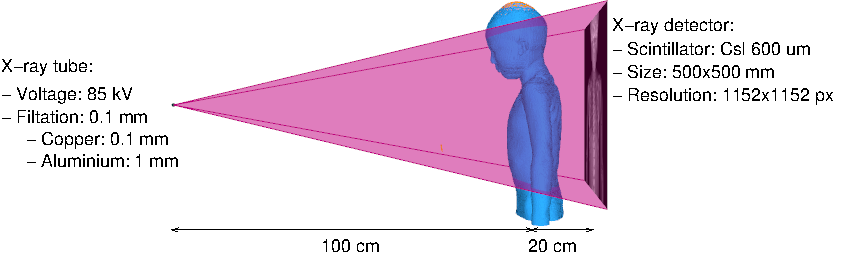

In [4]:
Image(filename="pediatric-setup.png")

**Results:** The X-ray image can be retrieved from the GPU and saved on the disk, or displayed using Matplotlib or others, using various look-up tables.

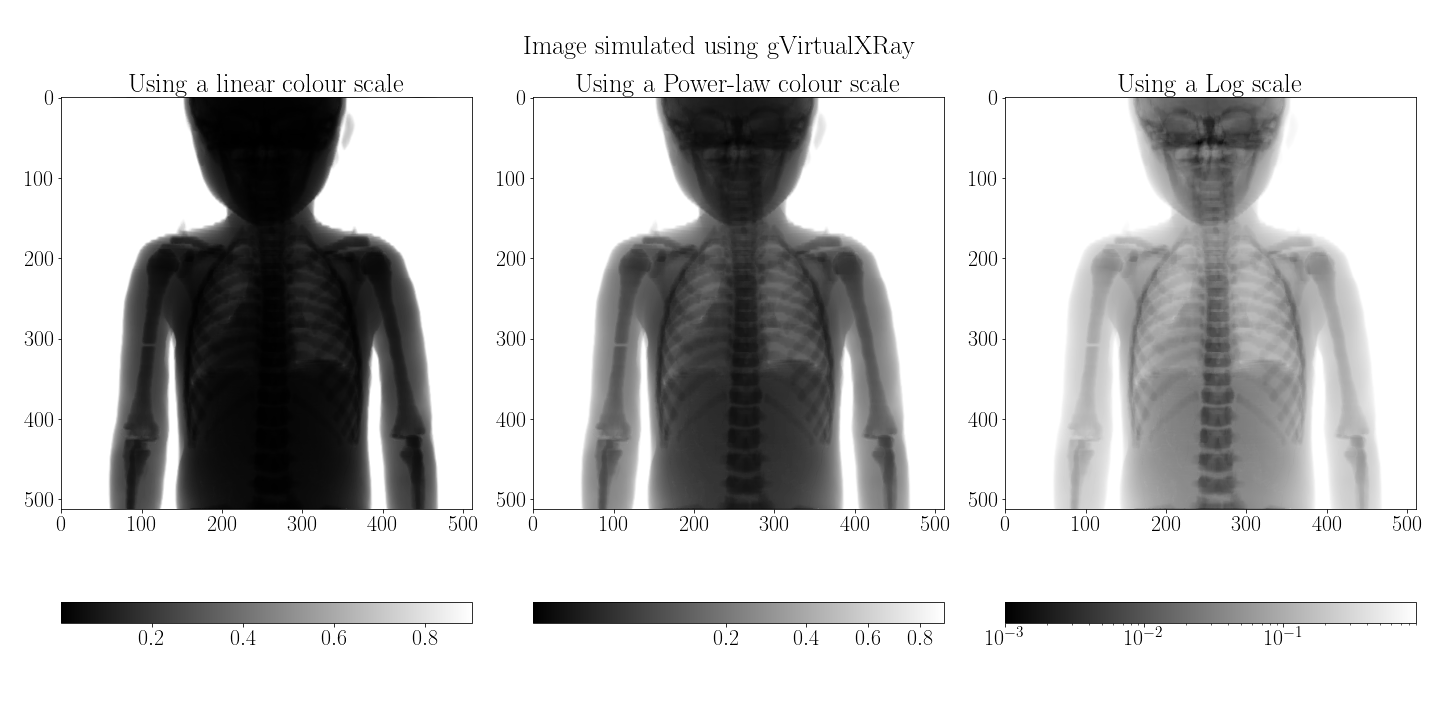

In [5]:
Image(filename="xray_image.png")

They can be converted into sinograms.

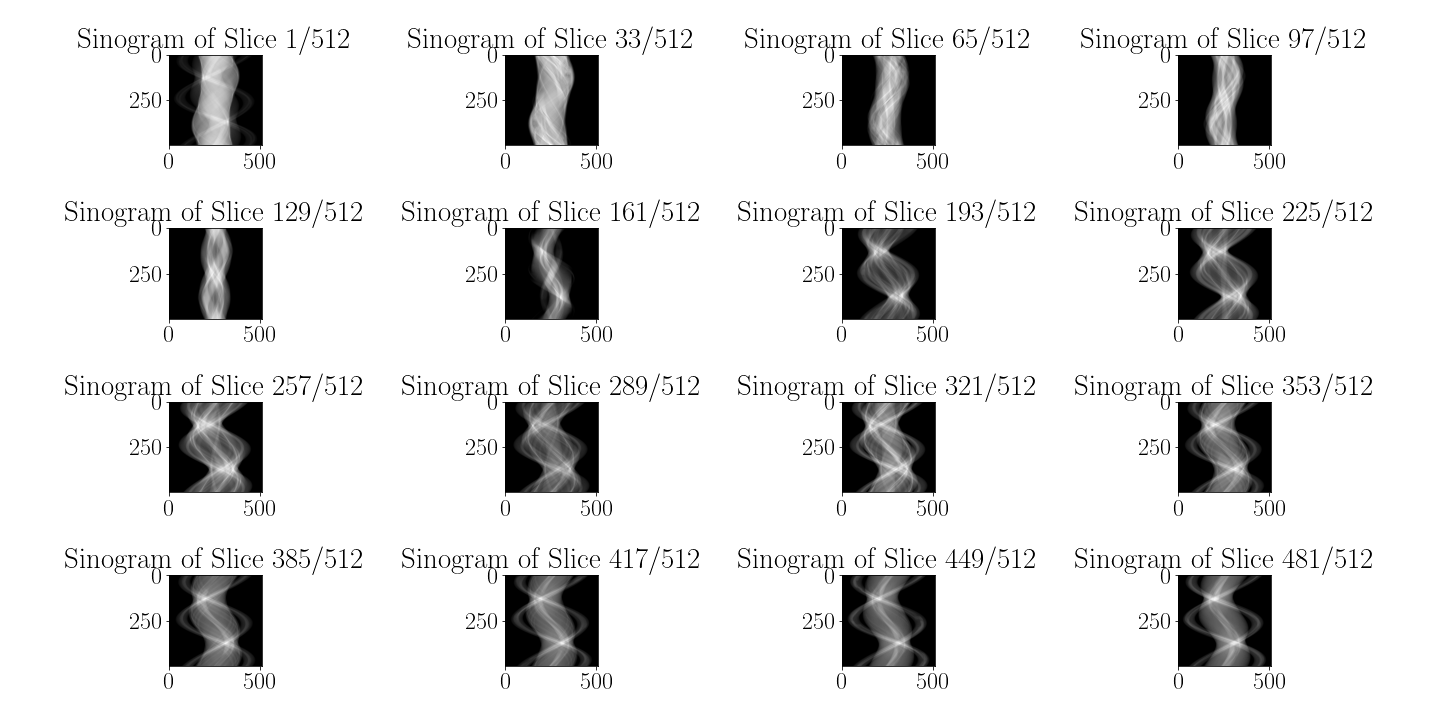

In [6]:
Image(filename="sinograms.png")

And reconstructed using a tomography reconstruction algorithm such as the algorithm of Feldkamp, Davis, and Kress (FDK) implemented in TIGRE.

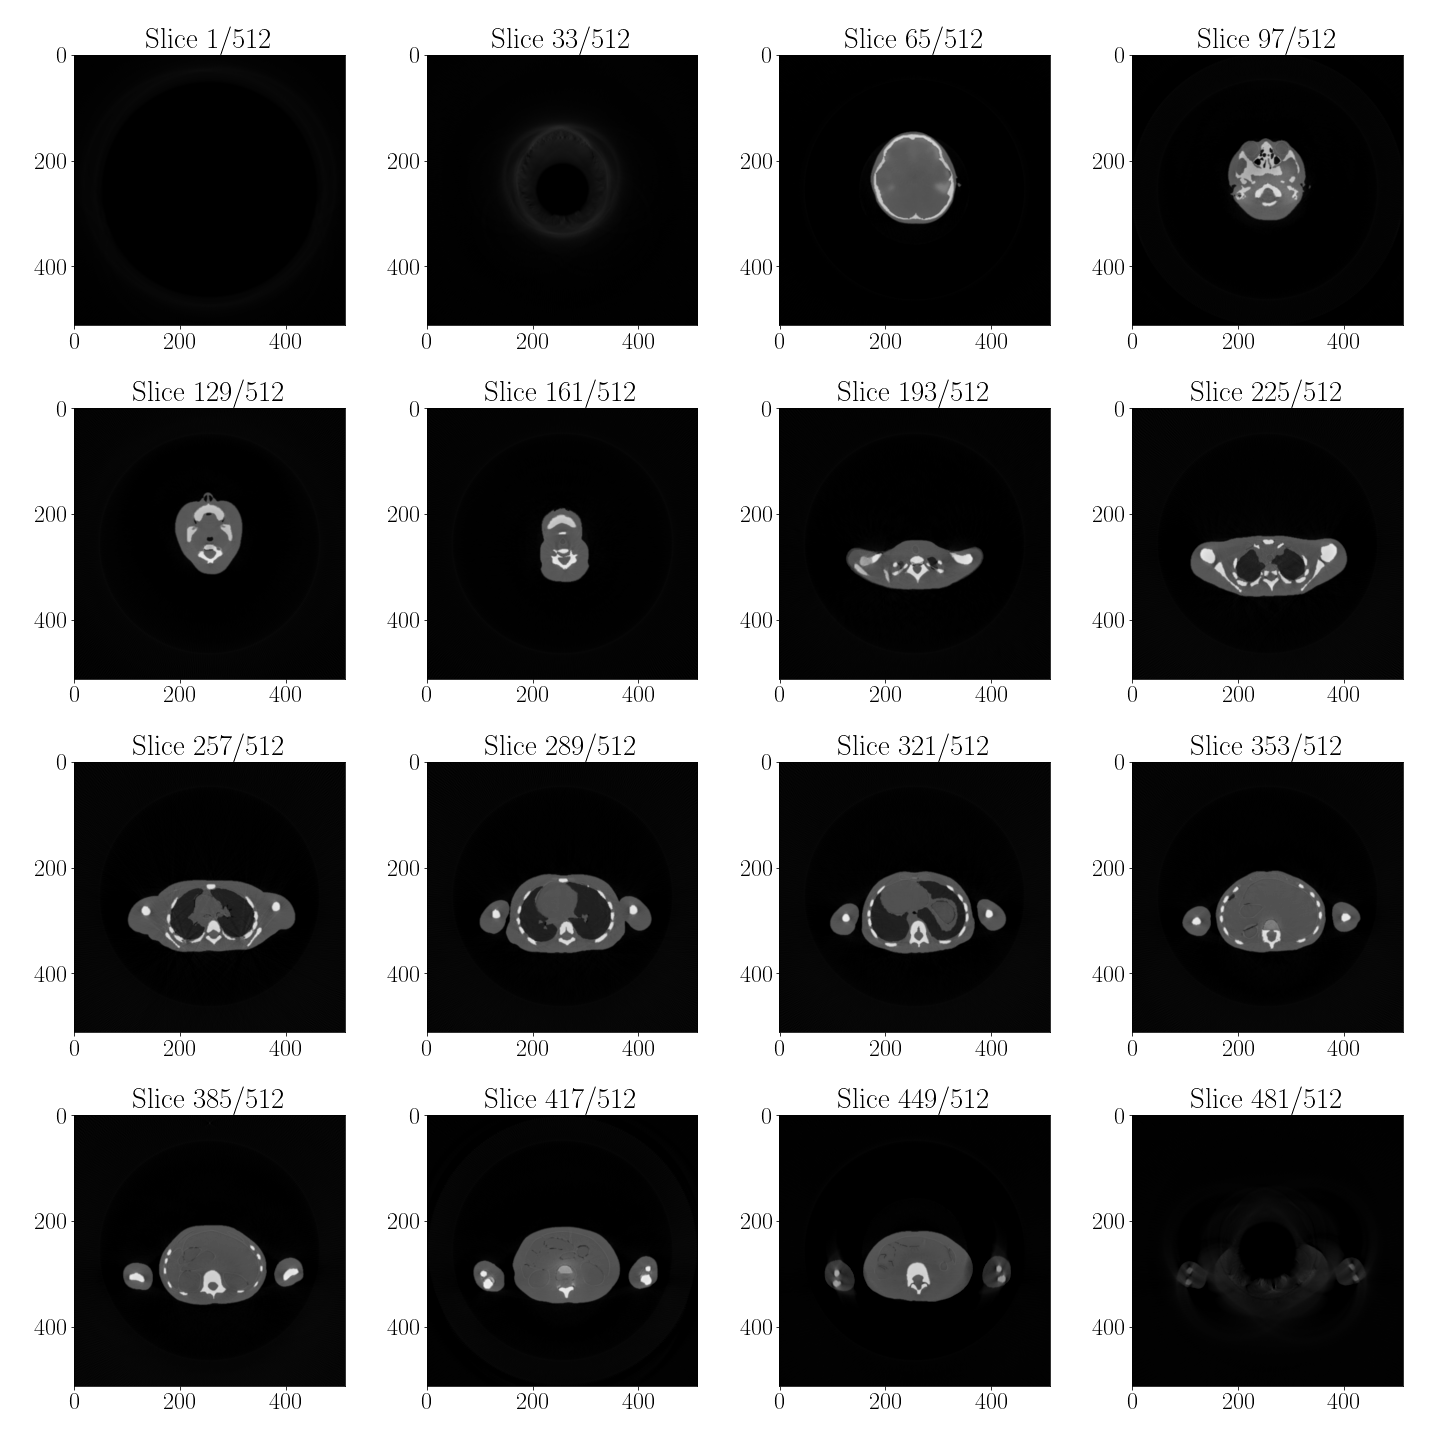

In [7]:
Image(filename="CT_slices.png")

The calculations were performed on the following platform:

In [8]:
printSystemInfo()

OS:
	Linux 5.3.18-lp152.20.7-default
	x86_64

CPU:
 	Intel(R) Core(TM) i9-9900K CPU @ 3.60GHz

RAM:
	31 GB
GPU:
	Name: NVIDIA GeForce RTX 2080 Ti
	Drivers: 470.42.01
	Video memory: 11 GB


## Import packages

In [9]:
import os # Locate files

import math
import numpy as np # Who does not use Numpy?
import pandas as pd # Load/Write CSV files

import urllib, zipfile

from time import sleep

import matplotlib

import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
from matplotlib.colors import PowerNorm # Look up table

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 22
       }
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)


from tifffile import imsave # Write TIFF files
import imageio

import k3d, base64
import SimpleITK as sitk
from stl import mesh

from sitk2vtk import sitk2vtk
import vtk

import tigre
import tigre.algorithms as algs

import gvxrPython3 as gvxr # Simulate X-ray images
import json2gvxr # Set gVirtualXRay and the simulation up

SimpleGVXR 1.0.1 (2021-12-13T16:30:11) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2021-12-13T16:30:10) [Compiler: GNU g++] on Linux


In [10]:
number_of_projections = 500 #1000
angular_step_deg = 360 / number_of_projections
angular_step_radian = angular_step_deg * math.pi / 180
theta_deg = np.linspace(0.0, angular_step_deg * number_of_projections, num=number_of_projections, endpoint=False)

In [11]:
print("Number of projections:", theta_deg.shape[0])
print("Angle between successive projections:", angular_step_deg)
print("First angle:", theta_deg[0])
print("Last angle:", theta_deg[-1])

Number of projections: 500
Angle between successive projections: 0.72
First angle: 0.0
Last angle: 359.28


## Define some useful functions

In [12]:
def recons(proj, angles, mode="cone", filter="hann"):

    # Using TIGRE
    #Geometry settings
    source_position = gvxr.getSourcePosition("mm")
    detector_position = gvxr.getDetectorPosition("mm")

    geo = tigre.geometry(mode='cone',  default=False)

    # Distance Source Origin        (mm)
    geo.DSO = math.sqrt(source_position[0] ** 2 + source_position[1] ** 2 + source_position[2] ** 2)

    # Distance Detector Origin        (mm)
    DDO = math.sqrt(detector_position[0] ** 2 + detector_position[1] ** 2 + detector_position[2] ** 2)

    # Distance Source Detector      (mm)
    geo.DSD = geo.DSO + DDO


    # Detector parameters
    # number of pixels              (px)
    geo.nDetector = np.array([gvxr.getDetectorNumberOfPixels()[1], gvxr.getDetectorNumberOfPixels()[0]])

    # total size of the detector    (mm)
    geo.sDetector = np.array([gvxr.getDetectorSize("mm")[1], gvxr.getDetectorSize("mm")[0]])

    # size of each pixel            (mm)
    geo.dDetector = geo.sDetector / geo.nDetector


    # Image parameters
    geo.nVoxel = np.array((geo.nDetector[0], geo.nDetector[1], geo.nDetector[1]))             # number of voxels              (vx)
    geo.sVoxel = np.array((geo.sDetector[0], geo.sDetector[1], geo.sDetector[1]))             # total size of the image       (mm)
    geo.dVoxel = geo.sVoxel / geo.nVoxel               # size of each voxel            (mm)

    # Offsets
    geo.offOrigin = np.array((0, 0, 0))                # Offset of image from origin   (mm)
    geo.offDetector = np.array((0, 0))                 # Offset of Detector            (mm)

    # Auxiliary
    geo.accuracy = 0.5                                 # Accuracy of FWD proj          (vx/sample)

    # Mode
    geo.mode = 'cone'                                  # parallel, cone                ...
    geo.filter = filter                       #  None, shepp_logan, cosine, hamming, hann

    #Reconstruction with FDK
    return algs.fdk(proj, geo, angles)

    # Using TOMOPY
#     theta_rad = np.array(theta_deg) * math.pi / 180
#     rot_centre = minus_log_projs.shape[2] / 2
#     # rot_centre = tomopy.find_center(minus_log_projs, theta_rad, init=rot_centre, ind=0, tol=0.01)
#     print("Projection sizes:", minus_log_projs.shape)
#     print("Rotation centre:", rot_centre)
#     CT_volume_in_mu = tomopy.recon(minus_log_projs,
#                              theta_rad,
#                              center=rot_centre,
#                              algorithm='gridrec',
#                              sinogram_order=False,
#                              filter_name='shepp')


# if not os.path.exists("CT-volume.mha"):
#     CT_volume_in_mu = []

#     for sinogram in sinograms:
#         CT_volume_in_mu.append(iradon(sinogram.T, theta=theta_deg, circle=True))

# sinogram = None # Not needed anymore
#     print("Volume size:", CT_volume_in_mu.shape)
# sinogram = None # Not needed anymore

In [13]:
total_energy = None

def flatFieldCorrection(proj):
    
    global total_energy
    
    if total_energy is None:

        # Retrieve the total energy
        total_energy = 0.0;
        energy_bins = gvxr.getEnergyBins("MeV");
        photon_count_per_bin = gvxr.getPhotonCountEnergyBins();

        for energy, count in zip(energy_bins, photon_count_per_bin):
            total_energy += energy * count;

    # Create a mock dark field image
    #dark_field_image = np.zeros(raw_projections.shape);
    dark_field_image = 0.0

    # Create a mock flat field image
    #flat_field_image = np.ones(raw_projections.shape);
    flat_field_image = 1.0

    flat_field_image *= total_energy
    
    return (np.array(proj).astype(np.single) - dark_field_image) / (flat_field_image - dark_field_image)

In [14]:
def minusLog(proj):

    minus_log_projs = np.copy(proj)
    
    # Make sure no value is negative or null (because of the log function)
    # It should not be the case, however, when the Laplacian is used to simulate
    # phase contrast, negative values can be generated.
    threshold = 0.000000001
    minus_log_projs[minus_log_projs < threshold] = threshold;

    # Apply the minus log normalisation
    minus_log_projs = -np.log(minus_log_projs);

    # Rescale the data taking into account the pixel size
    pixel_spacing_in_mm = gvxr.getDetectorSize("mm")[0] / gvxr.getDetectorNumberOfPixels()[0]
    minus_log_projs /= pixel_spacing_in_mm * (gvxr.getUnitOfLength("mm") / gvxr.getUnitOfLength("cm"));

    # Make sure the data is in single-precision floating-point numbers
    return minus_log_projs.astype(np.single)

## Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [15]:
json2gvxr.initGVXR("configuration.json", "OPENGL")

Create an OpenGL context: 800x450
gvxrStatus:	Create window 0
gvxrStatus:	Create window 
0 0 500 500
OpenGL renderer:   NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
OpenGL version:    3.2.0 NVIDIA 470.42.01
OpenGL vender:     NVIDIA Corporation
Use OpenGL 4.5.
0 0 800 450


## X-ray source

We create an X-ray source. It is a point source.

In [16]:
json2gvxr.initSourceGeometry()

Set up the beam
	Source position: [0.0, -1000.0, 0.0, 'mm']
	Source shape: PointSource


## Spectrum

The spectrum is polychromatic.

In [17]:
spectrum, unit, k, f = json2gvxr.initSpectrum(verbose=0)
energy_set = sorted(spectrum.keys())

count_set = []

for energy in energy_set:
    count_set.append(spectrum[energy])

params["Source"]["Beam"] {'kvp': 85, 'tube angle': 12, 'filter': [['Al', 1], ['Cu', 0.1]]}
['Al', 1]
['Cu', 0.1]


Plot the spectrum

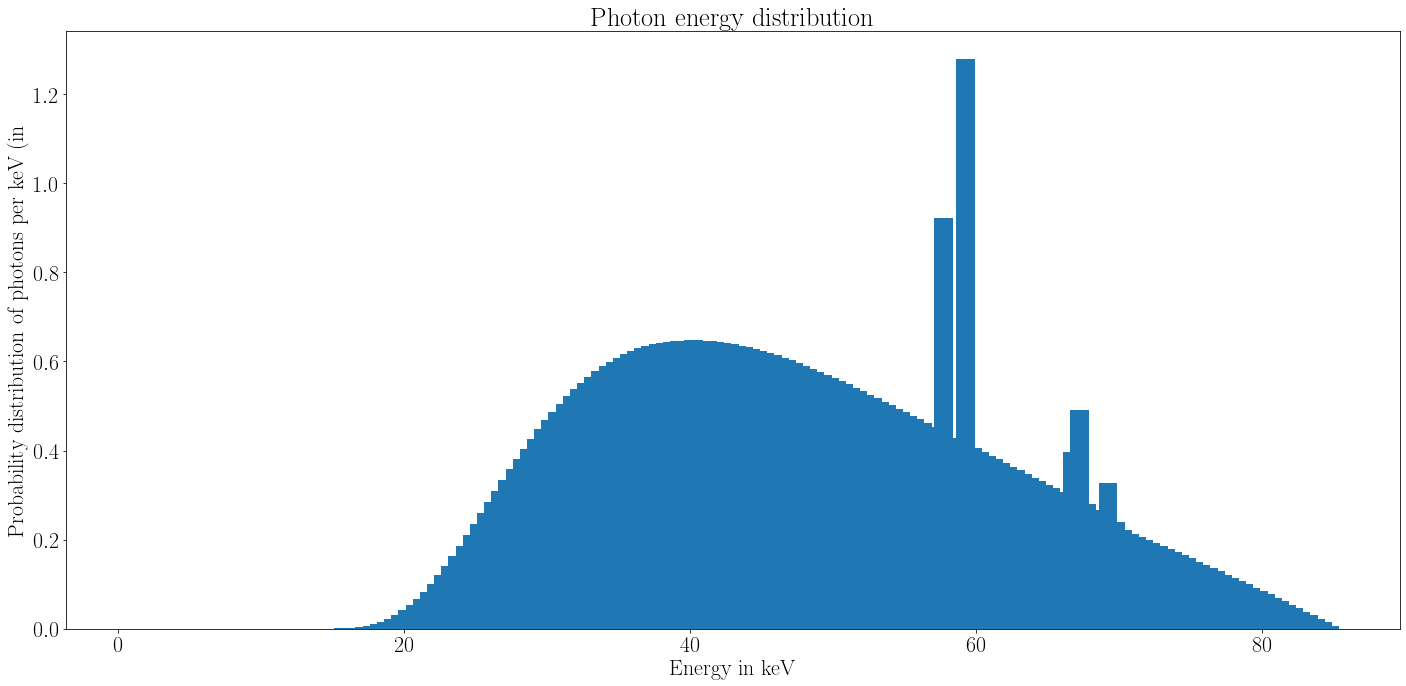

In [18]:
plt.figure(figsize= (20,10))

plt.bar(k, 100 * f / f.sum()) # Plot the spectrum
plt.xlabel('Energy in keV')
plt.ylabel('Probability distribution of photons per keV (in %)')
plt.title('Photon energy distribution')

# plt.xlim(())

plt.tight_layout()

## Detector

Create a digital detector

In [19]:
json2gvxr.initDetector()

Set up the detector
	Detector position: [0.0, 200.0, 0.0, 'mm']
	Detector up vector: [0, 0, -1]
	Detector number of pixels: [512, 512]
	Energy response: responseDetector.txt in MeV
	Pixel spacing: [0.9765625, 0.9765625, 'mm']
INIT RENDER


## Model the energy response of the detector

Load the energy response

In [20]:
detector_response = np.loadtxt(json2gvxr.params["Detector"]["Energy response"]["File"])

Display the energy response

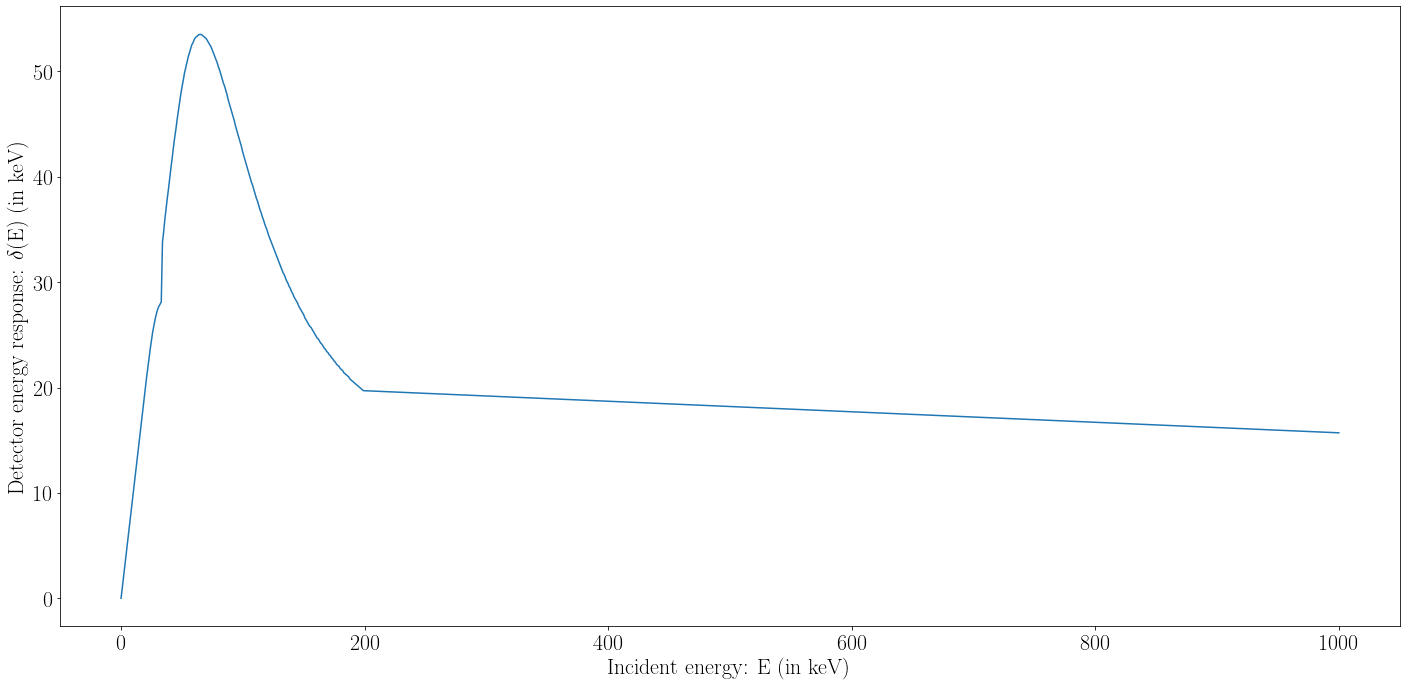

In [21]:
plt.figure(figsize= (20,10))
# plt.title("Detector response")
plt.plot(detector_response[:,0] * 1000, detector_response[:,1] * 1000)
plt.xlabel('Incident energy: E (in keV)')
plt.ylabel('Detector energy response: $\\delta$(E) (in keV)')

plt.tight_layout()

## Sample

Download and unzip the phantom

In [22]:
if not os.path.exists("pediatric_phantom_data"):
    os.mkdir("pediatric_phantom_data")

if not os.path.exists("pediatric_phantom_data/Pediatric phantom.zip"):
    urllib.request.urlretrieve("https://drive.uca.fr/f/384a08b5f73244cf9ead/?dl=1", "pediatric_phantom_data/Pediatric phantom.zip")

    with zipfile.ZipFile("pediatric_phantom_data/Pediatric phantom.zip","r") as zip_ref:
        zip_ref.extractall("pediatric_phantom_data")

Load the phantom

In [23]:
phantom = sitk.ReadImage("pediatric_phantom_data/Pediatric phantom/Pediatric_model.mhd")

Load the labels

In [24]:
df = pd.read_csv("labels.dat")

Process every structure of the phantom

In [25]:
# A function to extract an isosurface from a binary image
def extractSurface(vtk_image, isovalue):

    iso = vtk.vtkContourFilter()
    if vtk.vtkVersion.GetVTKMajorVersion() >= 6:
        iso.SetInputData(vtk_image)
    else:
        iso.SetInput(vtk_image)

    iso.SetValue(0, isovalue)
    iso.Update()
    return iso.GetOutput()

# A function to write STL files
def writeSTL(mesh, name):
    """Write an STL mesh file."""
    try:
        writer = vtk.vtkSTLWriter()
        if vtk.vtkVersion.GetVTKMajorVersion() >= 6:
            writer.SetInputData(mesh)
        else:
            writer.SetInput(mesh)
        writer.SetFileTypeToBinary()
        writer.SetFileName(name)
        writer.Write()
        writer = None
    except BaseException:
        print("STL mesh writer failed")
        exc_type, exc_value, exc_traceback = sys.exc_info()
        traceback.print_exception(
            exc_type, exc_value, exc_traceback, limit=2, file=sys.stdout)
    return None


In [26]:
if not os.path.exists("pediatric_phantom_data/meshes"):
    os.mkdir("pediatric_phantom_data/meshes")

if not os.path.exists("pediatric_phantom_data/segmentations"):
    os.mkdir("pediatric_phantom_data/segmentations")

meshes = []

for threshold, organ in zip(df["Label"], df["Organs"]):

    # Ignore air
    if organ != "Air":

        print("Process", organ)
        
        seg_fname = "pediatric_phantom_data/segmentations/" + organ + ".mha"
        mesh_fname = "pediatric_phantom_data/meshes/" + organ + ".stl"
        meshes.append(mesh_fname)

        # Only create the mesh if it does not exist
        if not os.path.exists(mesh_fname):

            # Threshold the phantom
            binary_image = (phantom == threshold)

            # Smooth the binary segmentation
            smoothed_binary_image = sitk.AntiAliasBinary(binary_image)
                            
            # Create a VTK image
            vtkimg = sitk2vtk(smoothed_binary_image, centre=True)

            vtk_mesh = extractSurface(vtkimg, 0)
            writeSTL(vtk_mesh, mesh_fname)

Process Muscle
Process Bone
Process Stomach-Interior
Process Cartilage
Process Brain
Process Bladder
Process Gallbladder
Process Heart
Process Kidneys-right
Process Kidneys-left
Process Small-Intestine
Process Large-Intestine
Process Liver
Process Lung-right
Process Lung-left
Process Pancreas
Process Spleen
Process Stomach
Process Thymus
Process Eyes-right
Process Eyes-left
Process Skull
Process Trachea


Load the samples. `verbose=2` is used to print the material database for Gate. To disable it, use `verbose=0` or `verbose=1`.

In [27]:
json2gvxr.initSamples(verbose=0)

file_name:	pediatric_phantom_data/meshes/Muscle.stl	nb_faces:	1756726	nb_vertices:	5270178	bounding_box (in cm):	(-17.9687, -10.8887, -30.9017)	(16.6016, 11.1799, 28.6986)
file_name:	pediatric_phantom_data/meshes/Bone.stl	nb_faces:	541826	nb_vertices:	1625478	bounding_box (in cm):	(-16.7969, -23.6577, -30.9017)	(15.2152, 9.88865, 16.3501)
file_name:	pediatric_phantom_data/meshes/Stomach-Interior.stl	nb_faces:	9452	nb_vertices:	28356	bounding_box (in cm):	(-1.34334, -2.38867, -17.0041)	(4.16143, 3.05231, -8.50205)
file_name:	pediatric_phantom_data/meshes/Cartilage.stl	nb_faces:	163322	nb_vertices:	489966	bounding_box (in cm):	(-16.7615, -4.32288, -30.9017)	(15.5041, 8.717, 16.6771)
file_name:	pediatric_phantom_data/meshes/Brain.stl	nb_faces:	124028	nb_vertices:	372084	bounding_box (in cm):	(-7.32082, -9.98695, 16.3501)	(7.50031, 5.78681, 28.1222)
file_name:	pediatric_phantom_data/meshes/Bladder.stl	nb_faces:	3712	nb_vertices:	11136	bounding_box (in cm):	(-3.78536, 2.11808, -30.9017)	(0.

Visualise the phantom

In [28]:
plot = k3d.plot()
plot.background_color = 0xffffff

for sample in json2gvxr.params["Samples"]:
    
    label = sample["Label"]
    
    fname = sample["Path"]

    r, g, b, a = gvxr.getAmbientColour(label)
    R = math.floor(255*r)
    G = math.floor(255*g)
    B = math.floor(255*b)
    A = math.floor(255*a)

    k3d_color = 0;
    k3d_color |= (R & 255) << 16;
    k3d_color |= (G & 255) << 8;
    k3d_color |= (B & 255);

    mesh_from_stl_file = mesh.Mesh.from_file(fname)

    if label == "Muscle":
        opacity = 0.4
    else:
        opacity = 1
    geometry = k3d.mesh(mesh_from_stl_file.vectors.flatten(),
                          range(int(mesh_from_stl_file.vectors.flatten().shape[0] / 3)),
                          color=k3d_color, 
                          wireframe=False, 
                          flat_shading=False,
                          name=fname,
                          opacity=opacity)

    plot += geometry   

plot.display()
plot.camera = [321.6678075002728,   -461.4855245196105, -34.86613985320561,
                 0,                    0,                -1.635009765625,
                 0.08017827340927154, -0.083269170696295, 0.9932963755519574]

Output()

In [29]:
fname = 'pediatric_model.png'
if not os.path.isfile(fname):

    sleep(10)
    plot.fetch_screenshot() # Not sure why, but we need to do it twice to get the right screenshot
    sleep(10)

    data = base64.b64decode(plot.screenshot)
    with open(fname,'wb') as fp:
        fp.write(data)

# Dry run of the simulation

In [30]:
gvxr.enableArtefactFilteringOnGPU()
xray_image = np.array(gvxr.computeXRayImage())

In [31]:
xray_image_flat = flatFieldCorrection(xray_image)

In [32]:
gamma = 2

vmin = xray_image_flat.min()
vmax = xray_image_flat.max()

def interact_plot():

    fig_plot = plt.figure(figsize= (20,10))

    plt.suptitle("Image simulated using gVirtualXRay", y=0.95)
    ax = plt.subplot(131)
    plt.imshow(xray_image_flat, cmap="gray")
    plt.colorbar(orientation='horizontal')
    ax.set_title("Using a linear colour scale")

    ax_img = plt.subplot(132)
    plt.imshow(xray_image_flat, norm=PowerNorm(gamma=1./gamma), cmap="gray")
    plt.colorbar(orientation='horizontal')
    ax_img.set_title("Using a Power-law colour scale")

    ax = plt.subplot(133)
    plt.imshow(xray_image_flat, norm=LogNorm(vmin=vmin, vmax=vmax), cmap="gray")
    plt.colorbar(orientation='horizontal')
    ax.set_title("Using a Log scale")
    
    
    plt.tight_layout()
    plt.savefig('xray_image.png')
    plt.close()

    ## Callback function: plot y=Acos(x+phi)
    def update_plot(gamma):
        ax_img.imshow(xray_image_flat, norm=PowerNorm(gamma=1./gamma), cmap="gray")
        display(fig_plot)

    interact(update_plot,
             gamma=widgets.FloatSlider(value=gamma, min=0.01, max=10.0, step=0.5, description="gamma"))

interact_plot();

interactive(children=(FloatSlider(value=2.0, description='gamma', max=10.0, min=0.01, step=0.5), Output()), _d…

## Visualisation using gVirtualXRay

In [33]:
gvxr.displayScene()

gvxr.useLighing()
gvxr.useWireframe(False)
gvxr.useNegative(False)
gvxr.setZoom(1549.6787109375)

angle = math.pi / 2.0
rotation_matrix_x = np.array([ 1, 0, 0, 0,
                               0, math.cos(angle), -math.sin(angle), 0,
                               0, math.sin(angle),  math.cos(angle), 0,
                               0, 0, 0, 1])

rotation_matrix_z = np.array([ math.cos(angle), -math.sin(angle), 0, 0,
                               math.sin(angle),  math.cos(angle), 0, 0,
                               0, 0, 1, 0,
                               0, 0, 0, 1])

rotation_matrix_x.shape = [4,4]
rotation_matrix_z.shape = [4,4]

transformation_matrix = np.identity(4)

transformation_matrix = np.matmul(rotation_matrix_x, transformation_matrix)
transformation_matrix = np.matmul(rotation_matrix_z, transformation_matrix)

gvxr.setSceneRotationMatrix(transformation_matrix.flatten())

gvxr.setWindowBackGroundColour(1, 1, 1)

gvxr.displayScene()

0 0 500 500
0 0 800 450


In [34]:
screenshot = (255 * np.array(gvxr.takeScreenshot())).astype(np.uint8)

In [35]:
fname = 'screenshot.png'

if not os.path.isfile(fname):
    plt.imsave(fname, screenshot)

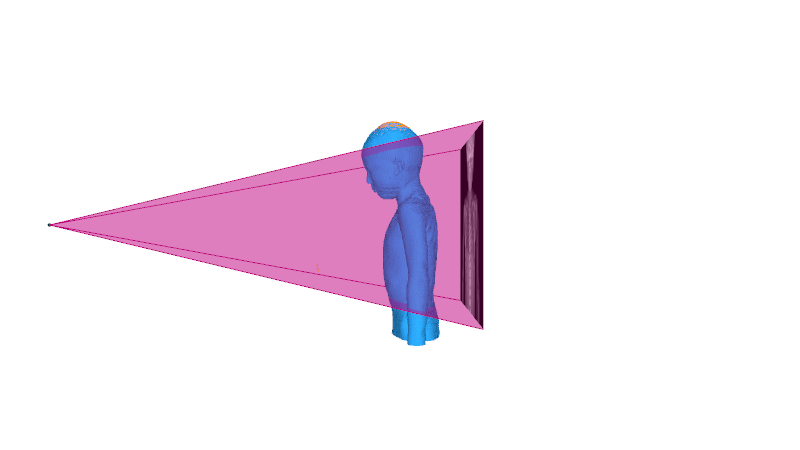

In [36]:
Image(filename="screenshot.png")

# Update the visualisation view

In [37]:
gvxr.setZoom(1549.6787109375)
gvxr.setSceneRotationMatrix([-0.19267332553863525, -0.06089369207620621, 0.9793692827224731,  0.0,
                              0.9809651970863342,  -0.03645244985818863, 0.19072122871875763, 0.0,
                              0.02408679760992527,  0.9974713325500488,  0.06675821542739868, 0.0, 
                              0.0,                  0.0,                 0.0,                 1.0])

gvxr.setWindowBackGroundColour(0.5, 0.5, 0.5)

gvxr.useNegative()

gvxr.displayScene()

# CT acquisition

In [38]:
nb_pixels = gvxr.getDetectorNumberOfPixels()
detector_size = gvxr.getDetectorSize("mm")
pixel_width = detector_size[0] / nb_pixels[0]
pixel_height = detector_size[1] / nb_pixels[1]

In [39]:
old_source_position = gvxr.getSourcePosition("mm")
old_detector_position = gvxr.getDetectorPosition("mm")

new_source_position = gvxr.getSourcePosition("mm")
new_detector_position = gvxr.getDetectorPosition("mm")

In [40]:
%%capture

matplotlib.rcParams.update({'font.size': 42})

if not os.path.exists("render"):
    os.mkdir("render")

if not os.path.exists("CT_acquisition.gif"):

    raw_projections = [];

    # Create a GIF file
    writer = None
    fname_gif = "CT_acquisition.gif"

    # if not os.path.exists(fname_gif):
    writer = imageio.get_writer(fname_gif, mode='I')

    i = 0
    
    rotation_axis = json2gvxr.params["Detector"]["UpVector"]
        
    raw_projections_1D = []
    angles = []
    
    for angle_id in range(0, number_of_projections):

        # Compute an X-ray image    
        xray_image = np.array(gvxr.computeXRayImage());

        # Add to the set of projections
        raw_projections.append(xray_image)
        angles.append(angle_id * angular_step_deg)
        
        # Update the rendering
        gvxr.displayScene();

        # Take a screenshot
        if writer is not None:
            if not angle_id % 15 or angle_id == number_of_projections - 1:
       
                ncols = 3
                nrows = 1

                fig = plt.figure(figsize= (40, 20))

                ax = fig.add_subplot(nrows, ncols, 1)
                ax.set_title("Projection " + str(angle_id + 1) + "/" + str(number_of_projections))
                screenshot = gvxr.takeScreenshot()
                ax.set_title("Projection " + str(angle_id + 1) + "/" + str(number_of_projections))
                plt.imshow(screenshot)
                plt.axis('off')
                
                # Flat-field corrections
                corrected_projections = flatFieldCorrection(raw_projections)
                
                # Create a temporary image to hold the sinogram
                minus_log_projs = minusLog(corrected_projections)
                
                sinograms = np.swapaxes(minus_log_projs, 0, 1)

                # Reconstruction
                theta_rad = np.array(angles) * math.pi / 180
                CT_volume_in_mu = recons(minus_log_projs, -theta_rad)
                ct_shepp_filter_image = recons(minus_log_projs, -theta_rad, filter="hann")
                
                # fname = 'sinograms/temp_' + format(i, '04') + '.tif'
                # imsave(fname, minus_log_projs)
                
                ax = fig.add_subplot(nrows, ncols, 2)
                ax.set_title("Sinogram of middle slice\n" + str(angle_id + 1) + "/" + str(number_of_projections))
                plt.imshow(sinograms[nb_pixels[1] // 2], cmap="gray", vmin=minus_log_projs.min(), vmax=minus_log_projs.max())
                plt.axis('off')
                
                ax = fig.add_subplot(nrows, ncols, 3)
                ax.set_title("FDK reconstruction of middle slice\nwith " + str(angle_id + 1) + " angles")
                plt.imshow(np.rot90(ct_shepp_filter_image[nb_pixels[1] // 2]), cmap="gray", vmin=0, vmax=ct_shepp_filter_image.max())
                plt.axis('off')

#                 fname = 'slices/temp_no_filter_' + format(i, '04') + '.tif'
#                 imsave(fname, ct_no_filter_image)

#                 fname = 'slices/temp_shepp_filter_' + format(i, '04') + '.tif'
#                 imsave(fname, ct_shepp_filter_image)

                plt.tight_layout()

                fname = 'render/temp_' + format(i, '04') + '.png'
                plt.savefig(fname, dpi=25)
                plt.close()

                # Add the image to the GIF file
                image = imageio.imread(fname)
                writer.append_data(image)                

                if angle_id == number_of_projections - 1:
                    for i in range(10):
                        writer.append_data(image)
                        print("Add last angle")

                i += 1
                

        # Rotate the source and the detector
        new_source_position = [
            new_source_position[0] * math.cos(angular_step_radian) - new_source_position[1] * math.sin(angular_step_radian),
            new_source_position[0] * math.sin(angular_step_radian) + new_source_position[1] * math.cos(angular_step_radian),
            new_source_position[2]
        ]
        
        new_detector_position = [
            new_detector_position[0] * math.cos(angular_step_radian) - new_detector_position[1] * math.sin(angular_step_radian),
            new_detector_position[0] * math.sin(angular_step_radian) + new_detector_position[1] * math.cos(angular_step_radian),
            new_detector_position[2]
        ]
        
        gvxr.setSourcePosition(new_source_position[0], new_source_position[1], new_source_position[2], "mm")
        gvxr.setDetectorPosition(new_detector_position[0], new_detector_position[1], new_detector_position[2], "mm")

    # Restore the source and the detector positions
    gvxr.setSourcePosition(old_source_position[0], old_source_position[1], old_source_position[2], "mm")
    gvxr.setDetectorPosition(old_detector_position[0], old_detector_position[1], old_detector_position[2], "mm")

    # Update the rendering
    gvxr.displayScene();

    # We're done with the writer
    if writer is not None:
        writer.close()
        # os.remove(temp.tif)

    # Convert to numpy arrays
    raw_projections = np.array(raw_projections)

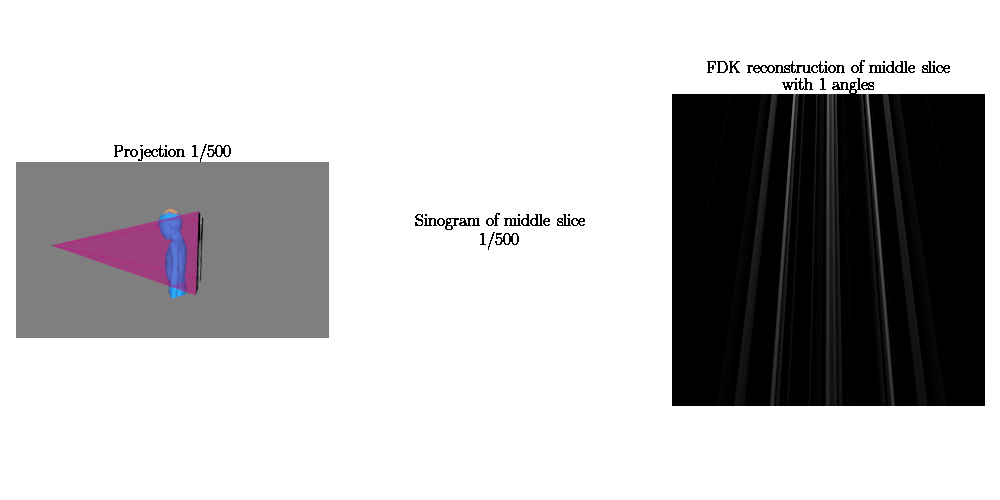

In [41]:
with open('CT_acquisition.gif','rb') as f:
    display(Image(data=f.read(), format='png', width=1000))

In [42]:
matplotlib.rcParams.update({'font.size': 24})

## Save the projections using SimpleITK

In [43]:
if not os.path.exists("raw_projections.mha"):

    raw_projections = np.array(raw_projections).astype(np.single)

    temp = sitk.GetImageFromArray(raw_projections)
    temp.SetSpacing([pixel_width, pixel_height, angular_step_deg])
    sitk.WriteImage(temp, "raw_projections.mha", useCompression=True) 
else:
    temp = sitk.ReadImage("raw_projections.mha")
    raw_projections = sitk.GetArrayFromImage(temp)

# Perform flat-field correction

In [44]:
if not os.path.exists("flat.mha"):

    # Flat-field corrections
    corrected_projections = flatFieldCorrection(raw_projections)

    sitk_image = sitk.GetImageFromArray(corrected_projections)
    sitk_image.SetSpacing([pixel_width, pixel_height, angular_step_deg])
    sitk.WriteImage(sitk_image, "flat.mha", useCompression=True) 

else:
    temp = sitk.ReadImage("flat.mha")
    corrected_projections = sitk.GetArrayFromImage(temp)
    
del raw_projections # Not needed anymore

## Calculate $-\log(\mathbf{corrected\_projections}) $ to linearize transmission tomography data

In [45]:
if not os.path.exists("sinograms.mha"):

    minus_log_projs = minusLog(corrected_projections)

    sitk_image = sitk.GetImageFromArray(minus_log_projs)
    sitk_image.SetSpacing([pixel_width, pixel_height, angular_step_deg])
    sitk.WriteImage(sitk_image, "sinograms.mha", useCompression=True)
    
else:
    temp = sitk.ReadImage("sinograms.mha")
    minus_log_projs = sitk.GetArrayFromImage(temp)
    
# Reformat the projections into a set of sinograms
sinograms = np.swapaxes(minus_log_projs, 0, 1)
sinograms = np.array(sinograms).astype(np.single)

del corrected_projections # Not needed anymore

Plot some sinograms

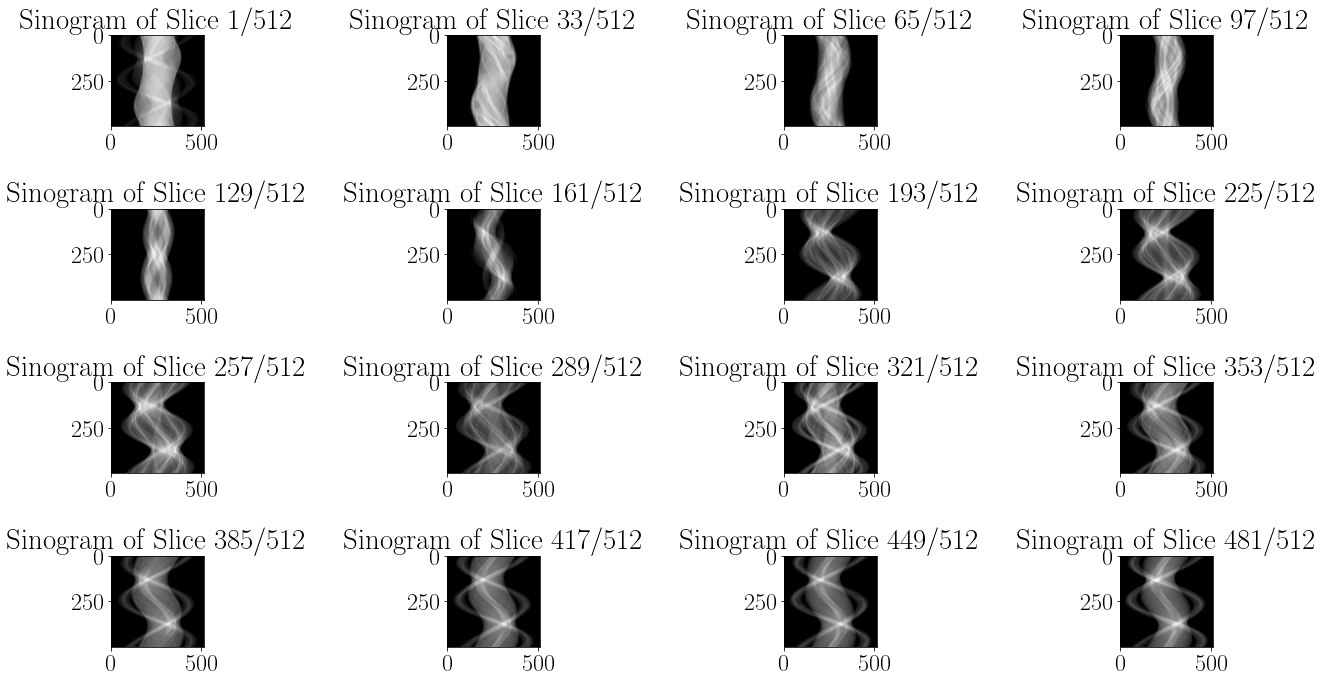

In [46]:
ncols = 4
nrows = 4

step = int(sinograms.shape[0] / (ncols * nrows))
slices = range(0, int(sinograms.shape[0]), step)

fig = plt.figure(figsize= (20, 10))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Sinogram of Slice " + str(slice_id + 1) + "/" + str(sinograms.shape[0]))
        ax.imshow(sinograms[slice_id], cmap='gray')
        
plt.tight_layout()

plt.savefig('sinograms.png')

In [47]:
if not os.path.exists("CT-volume.mha"):
    theta_rad = np.array(theta_deg) * math.pi / 180

    CT_volume_in_mu = recons(minus_log_projs, -theta_rad)
    
    sitk_image = sitk.GetImageFromArray(CT_volume_in_mu)
    sitk_image.SetSpacing([pixel_width, pixel_width, pixel_height])

    sitk_image.SetOrigin((-pixel_width * CT_volume_in_mu.shape[2] / 2.0,
                          -pixel_width * CT_volume_in_mu.shape[1] / 2.0,
                          -pixel_height * CT_volume_in_mu.shape[0] / 2.0))
    
    sitk.WriteImage(sitk_image, "CT-volume.mha", useCompression=True)

else:
    sitk_image = sitk.ReadImage("CT-volume.mha")
    CT_volume_in_mu = sitk.GetArrayFromImage(sitk_image)

del sinograms # Not needed anymore
del minus_log_projs # Not needed anymore

Display the CT slices

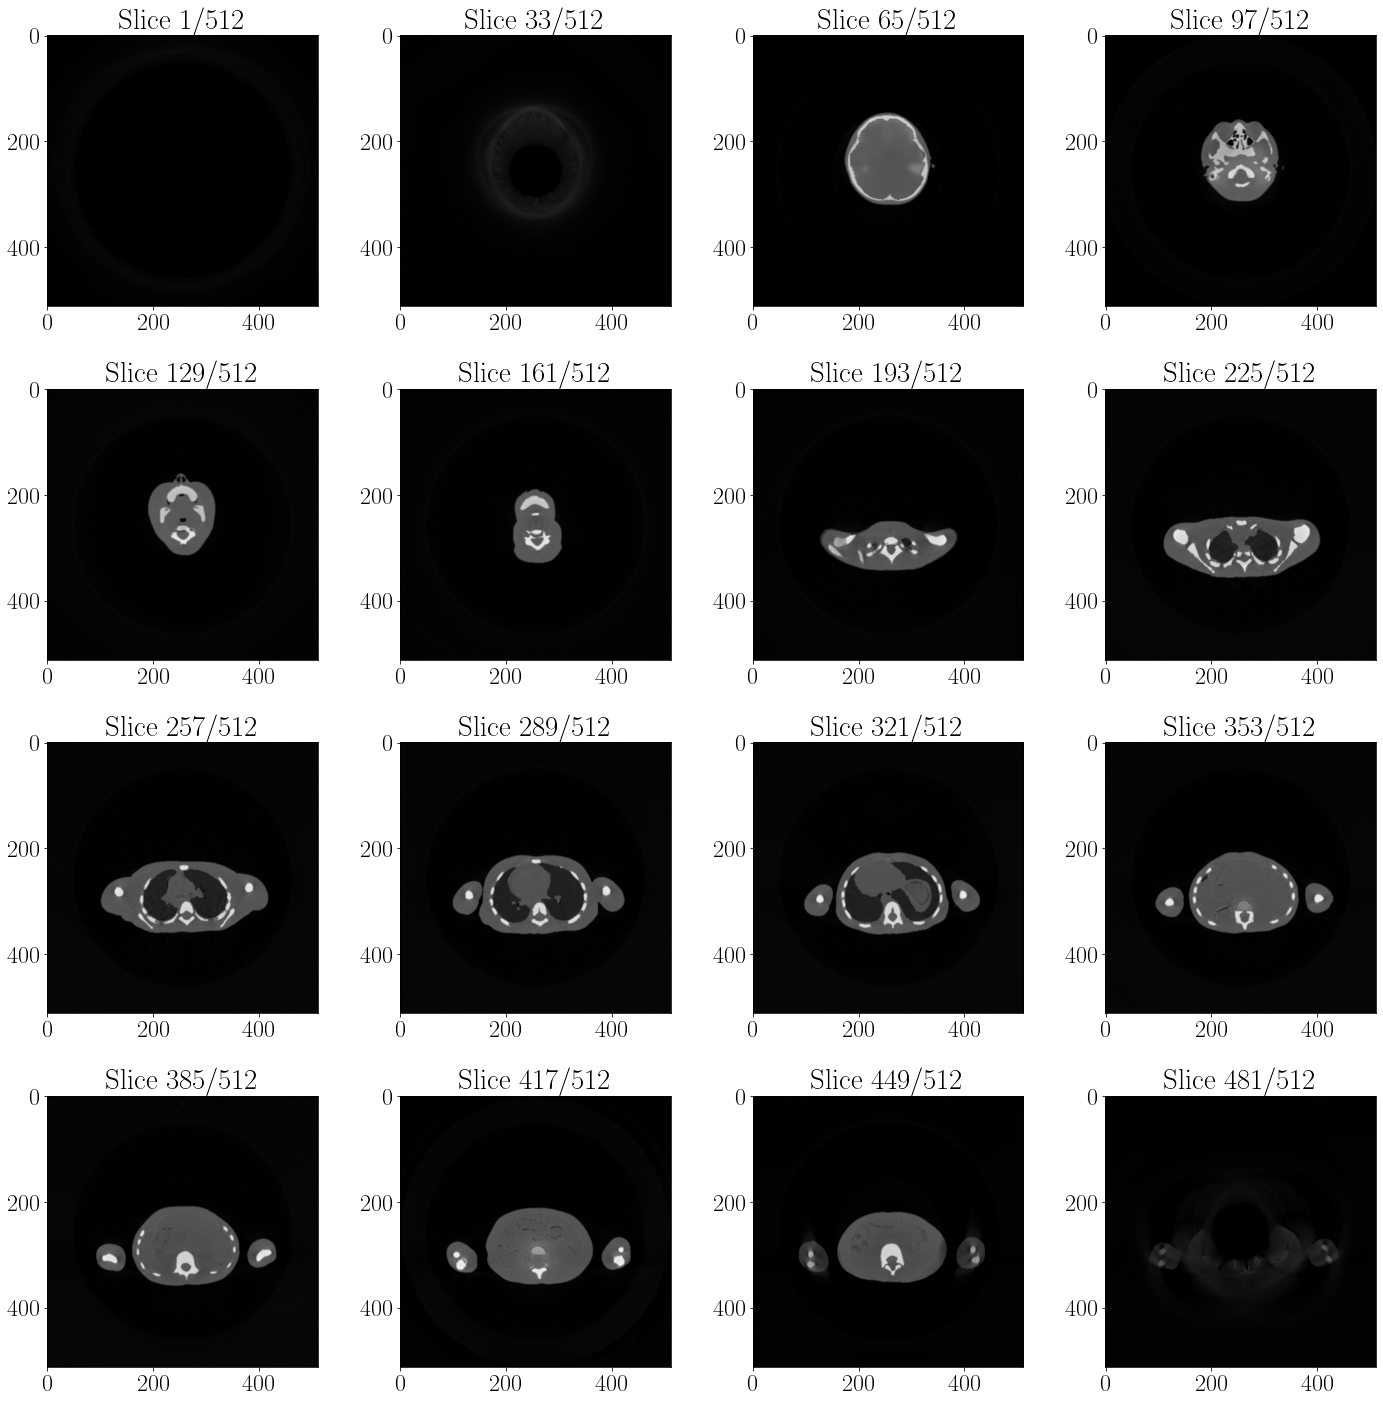

In [48]:
ncols = 4
nrows = 4

step = int(CT_volume_in_mu.shape[0] / (ncols * nrows))
slices = range(0, int(CT_volume_in_mu.shape[0]), step)

fig = plt.figure(figsize= (20,20))

for i in range(ncols):
    for j in range(nrows):
        index = j * ncols + i
        
        slice_id = slices[index]
        
        ax = fig.add_subplot(nrows, ncols, index + 1)
        ax.set_title("Slice " + str(slice_id + 1) + "/" + str(CT_volume_in_mu.shape[0]))
        ax.imshow(np.rot90(CT_volume_in_mu[slice_id]), cmap='gray', vmin=0, vmax=CT_volume_in_mu.max())
        
plt.tight_layout()

plt.savefig('CT_slices.png')

## All done

Destroy the window

In [49]:
gvxr.destroyAllWindows()

gvxrStatus:	Destroy all the windows
gvxrStatus:	Destroy window 0(0x55d144ab3750)
